# <center>_Toxic Comment Detection_</center>

## ___Loading Data___

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("labeled.csv", sep=",")
df['toxic'] = df['toxic'].apply(int)

___

## ___EDA___

In [3]:
df.shape

(14412, 2)

In [4]:
df['toxic'].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [5]:
df.query('toxic == 1')['comment']

0                     Верблюдов-то за что? Дебилы, бл...\n
1        Хохлы, это отдушина затюканого россиянина, мол...
2                                Собаке - собачья смерть\n
3        Страницу обнови, дебил. Это тоже не оскорблени...
4        тебя не убедил 6-страничный пдф в том, что Скр...
                               ...                        
14404    ЖЕНЩИНА это ВЕНЕЦ ТВОРЕНИЯ, помните это ваньки...
14405    Сейчас все авиакомпании мира вместе со специал...
14407    Вонючий совковый скот прибежал и ноет. А вот и...
14408    А кого любить? Гоблина тупорылого что-ли? Или ...
14410    КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...
Name: comment, Length: 4826, dtype: object

In [6]:
df.query('toxic == 0')['comment']

6        В шапке были ссылки на инфу по текущему фильму...
12       Почитайте посты у этого автора,может найдете ч...
17       Про графику было обидно) я так то проходил все...
28       https: pp.userapi.com c848520 v848520411 11627...
35       Возьмём как пример Россию, западноевропейские ...
                               ...                        
14392    ТАСС, 21 марта. Премьер-министр Новой Зеландии...
14399    65 А чего так мало? Вот у гражданина был рейти...
14406    Потому что запад прошел эту хуйню еще пару сот...
14409    Посмотрел Утомленных солнцем 2. И оказалось, ч...
14411    До сих пор пересматриваю его видео. Орамбо кст...
Name: comment, Length: 9586, dtype: object

In [7]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
# nltk.download('punkt')
# nltk.download('stopwords')

stemmer = SnowballStemmer(language='russian')
russian_stop_words = stopwords.words('russian')

def tokenize_sentence(sentence: str, remove_stop_words: bool=True):
    """Преобразует предложения в токены.
    По шагам:
    1) Токенизация - разбиение текста на отдельные слова и знаки пунктуации
    2) Удаляем знаки пунктуации
    3) Удаляем стоп-слова (часто используемые, не несущие смысловой нагрузки)
    4) Стемминг (stem - корень) - удаление окончаний и приведение к нижнему регистру
    """
    tokens = word_tokenize(sentence, language='russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [stemmer.stem(i) for i in tokens]
    return tokens

In [8]:
example = df.loc[1]['comment']
example

'Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.\n'

In [9]:
tokenize_sentence(example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True), 
                             token_pattern=None)

In [48]:
%%time

from sklearn.model_selection import train_test_split

features, labels = df['comment'], df['toxic']
features_vect = vectorizer.fit_transform(features)
x_train, x_test, y_train, y_test = train_test_split(features_vect, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    random_state=0)

CPU times: total: 17 s
Wall time: 17 s


___

## ___Testing Different Models___

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [13]:
def models_report(models, x_train, x_test, y_train, y_test):
    report = pd.DataFrame()
    #сюда можно вставить разделение выборки 
    for model in models:
        clf = models[model].fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        report.loc[model, 'Precision'] = precision_score(y_test, y_pred).round(4)
        report.loc[model, 'Recall'] = recall_score(y_test, y_pred).round(4)
        report.loc[model, 'F1-score'] = f1_score(y_test, y_pred).round(4)
        report.loc[model, 'ROC-AUC'] = roc_auc_score(y_test, y_pred).round(4)
    return report

In [14]:
models = {'kNN': KNeighborsClassifier(),
          'LogisticRegression': LogisticRegression(), 
          'SGDClassifier': SGDClassifier(loss='log_loss'), 
          'SVC': SVC(), 
          'XGBClassifier': XGBClassifier(), 
          'DecisionTree': DecisionTreeClassifier()}

In [15]:
%%time

models_report(models, x_train, x_test, y_train, y_test)

CPU times: total: 1min 35s
Wall time: 1min 17s


,Precision,Recall,F1-score,ROC-AUC
kNN,0.8192,0.5212,0.6371,0.7317
LogisticRegression,0.9160,0.5990,0.7243,0.7857
SGDClassifier,0.9175,0.5876,0.7164,0.7805
SVC,0.9123,0.6363,0.7497,0.8028
XGBClassifier,0.8931,0.5109,0.6500,0.7401
DecisionTree,0.7023,0.5917,0.6423,0.7328


___

## ___Search fo Hyperparameters___

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

### _kNN_

In [17]:
%%time

knn_grid = GridSearchCV(KNeighborsClassifier(), 
                        param_grid={'n_neighbors': range(10, 21)}, 
                        verbose=0,
                        cv=3)
knn_grid.fit(x_train, y_train)

print(f'best params: {knn_grid.best_params_}')
print(f' best score: {knn_grid.best_score_}')
print(classification_report(y_test, knn_grid.predict(x_test), digits=4))

best params: {'n_neighbors': 13}
 best score: 0.8251366120218581
              precision    recall  f1-score   support

           0     0.8153    0.9552    0.8797      1918
           1     0.8648    0.5699    0.6871       965

    accuracy                         0.8262      2883
   macro avg     0.8400    0.7626    0.7834      2883
weighted avg     0.8319    0.8262    0.8152      2883

CPU times: total: 7min 2s
Wall time: 2min 13s


___

### _Logistic Regression_

In [18]:
%%time

lr_grid = GridSearchCV(LogisticRegression(max_iter=300), 
                       param_grid={'C': np.logspace(-1, 2, 30)}, 
                       verbose=0,
                       cv=3)
lr_grid.fit(x_train, y_train)

print(f'best params: {lr_grid.best_params_}')
print(f' best score: {lr_grid.best_score_}')
print(classification_report(y_test, lr_grid.predict(x_test), digits=4))

best params: {'C': 23.95026619987486}
 best score: 0.8604388932257785
              precision    recall  f1-score   support

           0     0.8698    0.9400    0.9035      1918
           1     0.8580    0.7202    0.7831       965

    accuracy                         0.8665      2883
   macro avg     0.8639    0.8301    0.8433      2883
weighted avg     0.8658    0.8665    0.8632      2883

CPU times: total: 1min 8s
Wall time: 1min 3s


In [19]:
from sklearn.metrics import precision_recall_curve

pr, rc, ths = precision_recall_curve(y_true=y_test, 
                                     probas_pred=lr_grid.predict_proba(x_test)[:,1])

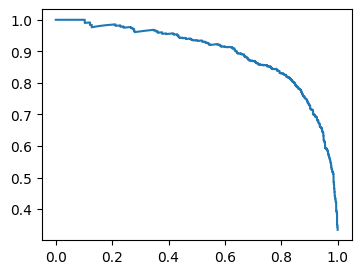

In [20]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(4, 3))
plt.plot(rc, pr)

In [21]:
pr_index = np.where(pr > 0.95)[0][0]
threshold = ths[pr_index].round(4)
probas = (lr_grid.predict_proba(x_test)[:,1] > threshold)
print(f'Precision: {precision_score(y_test, probas).round(4)}')
print(f'   Recall: {recall_score(y_test, probas).round(4)}')

Precision: 0.9501
   Recall: 0.4342


In [22]:
print(f'Threshold: {threshold}')

Threshold: 0.8662


___

### _Gradient Descent_

In [23]:
%%time

sgd_grid = GridSearchCV(SGDClassifier(loss='log_loss', early_stopping=True, validation_fraction=0.2, random_state=0), 
                        param_grid={'learning_rate': ['optimal'], 
                                    'alpha' : [0.00023, 0.001, 0.01]}, 
                        cv=5)
sgd_grid.fit(x_train, y_train)

print(f'best params: {sgd_grid.best_params_}')
print(f' best score: {sgd_grid.best_score_}')
print(classification_report(y_test, sgd_grid.predict(x_test), digits=4))

best params: {'alpha': 0.00023, 'learning_rate': 'optimal'}
 best score: 0.7991152383765447
              precision    recall  f1-score   support

           0     0.7840    0.9880    0.8743      1918
           1     0.9506    0.4591    0.6191       965

    accuracy                         0.8110      2883
   macro avg     0.8673    0.7235    0.7467      2883
weighted avg     0.8398    0.8110    0.7889      2883

CPU times: total: 797 ms
Wall time: 799 ms


In [24]:
scores = []
for alpha in np.linspace(0.0001, 0.001, 100):
    sgd_grid = SGDClassifier(loss='log_loss', 
                             alpha=alpha, 
                             early_stopping=True, 
                             validation_fraction=0.2, 
                             random_state=0)
    sgd_grid.fit(x_train, y_train)
    prec = precision_score(y_test, sgd_grid.predict(x_test))
    rec = recall_score(y_test, sgd_grid.predict(x_test))
    if prec > 0.95:
        scores.append((rec, alpha.round(6)))

In [25]:
max(scores)

(0.46217616580310883, 0.000227)

In [26]:
best_alpha = max(scores)[1]
best_alpha

0.000227

#### _Best SGD Classifier_

In [27]:
%%time

sgd = SGDClassifier(loss='log_loss', alpha=best_alpha, early_stopping=True, validation_fraction=0.2, random_state=0)
sgd.fit(x_train, y_train)

print(classification_report(y_test, sgd.predict(x_test), digits=4))

              precision    recall  f1-score   support

           0     0.7850    0.9880    0.8749      1918
           1     0.9510    0.4622    0.6220       965

    accuracy                         0.8120      2883
   macro avg     0.8680    0.7251    0.7485      2883
weighted avg     0.8406    0.8120    0.7903      2883

CPU times: total: 78.1 ms
Wall time: 82 ms


___

### _SVM_

In [47]:
%%time

svc_grid = GridSearchCV(SVC(), 
                        param_grid={'C': [0.9], 
                                    'gamma': [0.09]
                                   }, 
                        verbose=0, 
                        scoring='precision', 
                        cv=2)
svc_grid.fit(x_train, y_train)

print(f'best params: {svc_grid.best_params_}')
print(f' best score: {svc_grid.best_score_}')
print(classification_report(y_test, svc_grid.predict(x_test), digits=4))

best params: {'C': 0.9, 'gamma': 0.09}
 best score: 0.9732548410231892
              precision    recall  f1-score   support

           0     0.7414    0.9927    0.8489      1918
           1     0.9556    0.3119    0.4703       965

    accuracy                         0.7648      2883
   macro avg     0.8485    0.6523    0.6596      2883
weighted avg     0.8131    0.7648    0.7222      2883

CPU times: total: 35.4 s
Wall time: 35.5 s


___

### _XGBoost_

In [55]:
%%time

from sklearn.model_selection import cross_val_score

trees = [1] + list(range(2, 15))
xgb_scoring = []
for tree in trees:
    xgb = XGBClassifier(n_estimators=tree)
    score = cross_val_score(xgb, x_train, y_train, scoring='precision', cv=3)
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

CPU times: total: 37.4 s
Wall time: 11.4 s


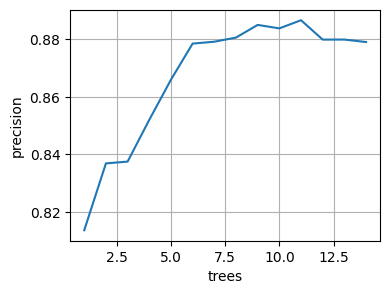

In [60]:
plt.figure(figsize=[4,3])
plt.plot(trees, xgb_scoring.mean(axis=1), label='XGBoost')
plt.grid(True)
plt.xlabel('trees')
plt.ylabel('precision')
plt.show()

In [39]:
trees = list(range(10, 110, 10))
scores = []
for tree in trees:
    xgb_grid = XGBClassifier(n_estimators=tree)
    xgb_grid.fit(x_train, y_train)
    prec = precision_score(y_test, xgb_grid.predict(x_test))
    rec = recall_score(y_test, xgb_grid.predict(x_test))
    if prec > 0.9:
        scores.append((rec, tree))

In [40]:
scores

[(0.32746113989637304, 20)]

тут еще есть варианты настроки параметров

___

### _Decision Tree_

In [41]:
%%time

dtc_grid = GridSearchCV(DecisionTreeClassifier(random_state=0), 
                        param_grid={'max_depth' : range(1, 20)}, 
                        cv=5)
dtc_grid.fit(x_train, y_train)

print(f'best params: {dtc_grid.best_params_}')
print(f' best score: {dtc_grid.best_score_}')
print(classification_report(y_test, dtc_grid.predict(x_test), digits=4))

best params: {'max_depth': 19}
 best score: 0.7398729711984016
              precision    recall  f1-score   support

           0     0.7300    0.9599    0.8293      1918
           1     0.7867    0.2943    0.4284       965

    accuracy                         0.7371      2883
   macro avg     0.7583    0.6271    0.6288      2883
weighted avg     0.7490    0.7371    0.6951      2883

CPU times: total: 1min 35s
Wall time: 1min 35s


In [42]:
scores = []
for n in range(1, 10):
    dtc_grid = DecisionTreeClassifier(random_state=0, max_depth=n)
    dtc_grid.fit(x_train, y_train)
    prec = precision_score(y_test, dtc_grid.predict(x_test))
    rec = recall_score(y_test, dtc_grid.predict(x_test))
    if prec > 0.95:
        scores.append((rec, n))

In [43]:
scores

[(0.04766839378238342, 1)]

___

## ___Predictions___

In [62]:
from sklearn.pipeline import Pipeline

In [63]:
x_train_pipe, x_test_pipe, y_train_pipe, y_test_pipe = train_test_split(features, 
                                                                        labels, 
                                                                        test_size=0.2, 
                                                                        random_state=0)

In [89]:
%%time
scores = []
for alpha in np.linspace(0.000277, 0.000283, 7):
    sgd_pipeline = Pipeline([('vectorizer', vectorizer), 
                             ('model', SGDClassifier(loss='log_loss', 
                                                     alpha=alpha, 
                                                     early_stopping=True, 
                                                     validation_fraction=0.2, 
                                                     random_state=0))])
    sgd_pipeline.fit(x_train_pipe, y_train_pipe)
    prec = precision_score(y_test_pipe, sgd_pipeline.predict(x_test_pipe))
    rec = recall_score(y_test_pipe, sgd_pipeline.predict(x_test_pipe))
    print((prec.round(4), rec.round(4)))
    if prec >= 0.949:
        scores.append((rec.round(4), alpha.round(6)))

(0.9455, 0.4497)
(0.9475, 0.4487)
(0.9496, 0.4487)
(0.9495, 0.4477)
(0.9495, 0.4477)
(0.9493, 0.4466)
(0.9493, 0.4466)
CPU times: total: 2min 25s
Wall time: 2min 25s


In [90]:
scores

[(0.4487, 0.000279),
 (0.4477, 0.00028),
 (0.4477, 0.000281),
 (0.4466, 0.000282),
 (0.4466, 0.000283)]

In [91]:
best_alpha_pipe = max(scores)[1]
best_alpha_pipe

0.000279

In [92]:
sgd_pipeline = Pipeline([('vectorizer', vectorizer), 
                         ('model', SGDClassifier(loss='log_loss', 
                                                 alpha=best_alpha_pipe, 
                                                 early_stopping=True, 
                                                 validation_fraction=0.2, 
                                                 random_state=0))])
sgd_pipeline.fit(x_train_pipe, y_train_pipe)
print(classification_report(y_test_pipe, sgd_pipeline.predict(x_test_pipe)))

              precision    recall  f1-score   support

           0       0.78      0.99      0.87      1918
           1       0.95      0.45      0.61       965

    accuracy                           0.81      2883
   macro avg       0.87      0.72      0.74      2883
weighted avg       0.84      0.81      0.78      2883



In [93]:
def check_toxic(text: str):
    if sgd_pipeline.predict([text])[0]:
        return 'TOXIC'
    else:
        return 'normal'

In [102]:
check_toxic('саня хуила')

'TOXIC'